# 1. Import libraries

In [46]:
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Data preprocessing

In [47]:
# === Katalog z raportami ===
REPORTS_DIR = "reports"

# === Mapowanie etykiet ===
labels = [
    'a', 'a+','b', 'c', 'c+', 'ch', 'cz', 'd', 'e', 'e+', 'f', 'g', 'h', 'i',
    'j', 'k', 'l', 'l+', 'm', 'n', 'n+', 'o', 'o+', 'p', 'r', 'rz', 's',
    's+', 'sz', 't', 'u', 'w', 'y', 'z', 'z+', 'z-'
]

# === Wzorce regex do metryk ===
metrics_pattern = {
    'Accuracy': re.compile(r"Accuracy:\s*([\d.]+)"),
    'Precision (macro)': re.compile(r"Precision \(macro\):\s*([\d.]+)"),
    'Recall (macro)': re.compile(r"Recall \(macro\):\s*([\d.]+)"),
    'F1 Score (macro)': re.compile(r"F1 Score \(macro\):\s*([\d.]+)"),
    'Training Time': re.compile(r"Czas treningu:\s*([\d.]+)")
}
model_pattern = re.compile(r"Model:\s*(.*)")
classification_pattern = re.compile(
    r"=== Klasyfikacja szczegółowa ===\n(.*?)\n\n", re.DOTALL)

# === Zbieranie danych ===
records = []
f1_scores = {label: [] for label in labels}  # Przechowywanie F1 score dla każdej etykiety

for filename in os.listdir(REPORTS_DIR):
    if filename.endswith(".txt"):
        with open(os.path.join(REPORTS_DIR, filename), encoding='utf-8') as f:
            content = f.read()

        # Nazwa modelu
        model_match = model_pattern.search(content)
        model_name = model_match.group(1).strip() if model_match else filename.replace('.txt', '')

        # Średnie metryki
        metrics = {'Model': model_name}
        for key, pattern in metrics_pattern.items():
            match = pattern.search(content)
            metrics[key] = float(match.group(1)) if match else None

        # Szczegółowa klasyfikacja – wczytaj linie po nagłówku
        lines = content.splitlines()
        try:
            start_idx = lines.index('=== Klasyfikacja szczegółowa ===') + 3  # +3 pomija nagłówek i nagłówki tabeli
            class_lines = lines[start_idx:start_idx + 36]  # 36 klas (0–35)
            detailed_scores = {}
            for i, line in enumerate(class_lines):
                parts = line.split()
                if len(parts) >= 4:
                    label = labels[i]  # mapuj według indeksu
                    precision, recall, f1 = map(float, parts[1:4])
                    detailed_scores[label] = {'Precision': precision, 'Recall': recall, 'F1': f1}
                    f1_scores[label].append(f1)
            metrics['Detailed'] = detailed_scores
        except ValueError:
            print(f"Nie znaleziono klasyfikacji szczegółowej w pliku {filename}")


        records.append(metrics)

# 3. Visualisation

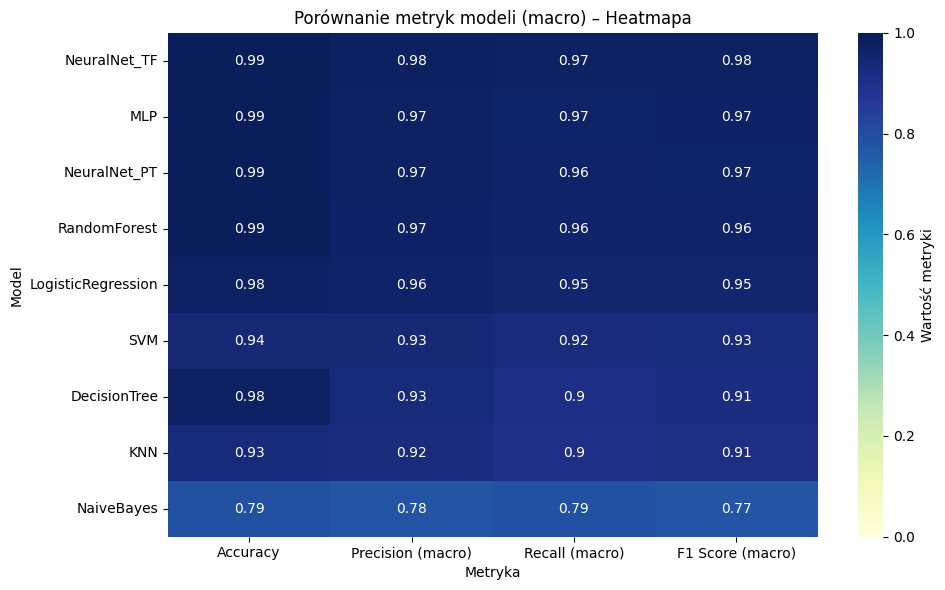

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5912\4234370887.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_sorted_time.index, y=df_sorted_time.values, palette="viridis")


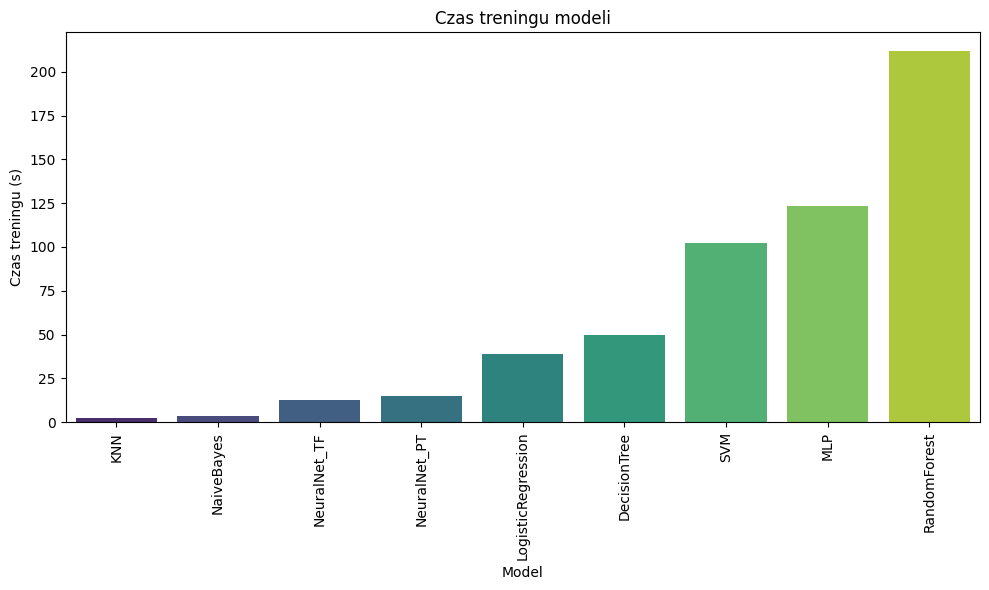

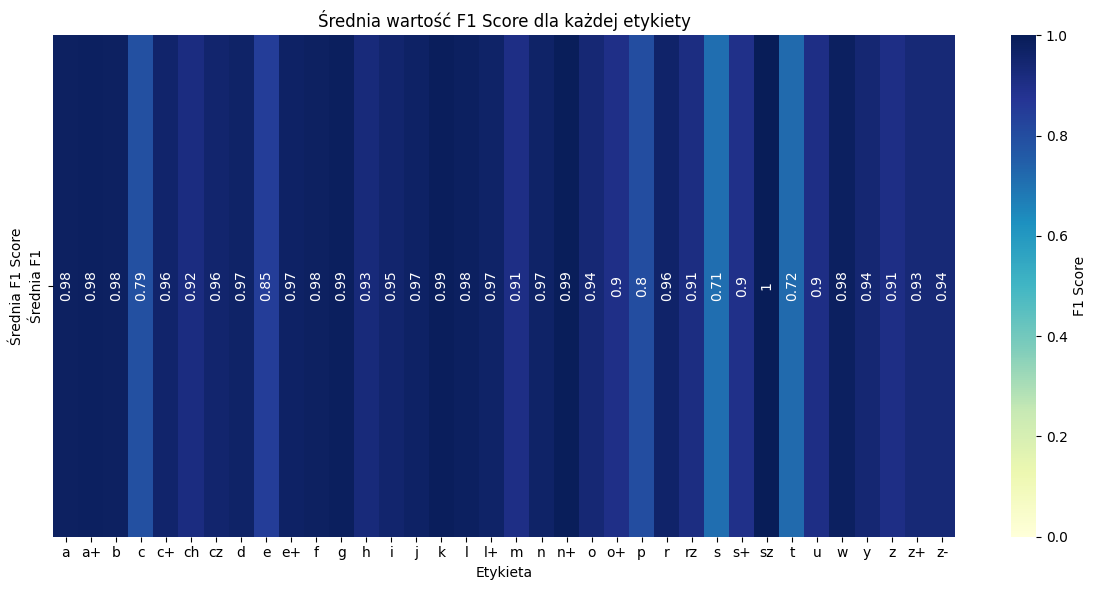

In [50]:
# === Tworzenie DataFrame ze średnich metryk ===
df = pd.DataFrame(records)
df_metrics = df.drop(columns=["Detailed"])
df_metrics.set_index("Model", inplace=True)

# === Obliczanie średniej skuteczności rozpoznawania znaków ===
df_metrics['Skuteczność rozpoznawania'] = df_metrics['F1 Score (macro)']

# === Sortowanie wg F1 Score i wizualizacja ===
df_sorted = df_metrics.sort_values(by='F1 Score (macro)', ascending=False)

plt.figure(figsize=(10, 6))
sns.heatmap(df_sorted[['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1 Score (macro)']],
            annot=True, cmap='YlGnBu', vmin=0, vmax=1, cbar_kws={'label': 'Wartość metryki'})
plt.title("Porównanie metryk modeli (macro) – Heatmapa")
plt.xlabel("Metryka")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

# === Wizualizacja Czasu Trenowania ===
plt.figure(figsize=(10, 6))
df_sorted_time = df_metrics['Training Time'].sort_values()
sns.barplot(x=df_sorted_time.index, y=df_sorted_time.values, palette="viridis")
plt.title("Czas treningu modeli")
plt.xlabel("Model")
plt.ylabel("Czas treningu (s)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# === Tworzenie heatmapy F1 Score dla każdej etykiety ===
f1_means = {label: sum(scores)/len(scores) if scores else 0 for label, scores in f1_scores.items()}
df_f1 = pd.DataFrame(list(f1_means.items()), columns=['Etykieta', 'Średnia F1'])
df_f1.set_index('Etykieta', inplace=True)

plt.figure(figsize=(12, 6))
sns.heatmap(
    df_f1.T,
    annot=True,
    annot_kws={'rotation': 90},
    cmap='YlGnBu',
    vmin=0,
    vmax=1,
    cbar_kws={'label': 'F1 Score'}
)
plt.title("Średnia wartość F1 Score dla każdej etykiety")
plt.xlabel("Etykieta")
plt.ylabel("Średnia F1 Score")
plt.tight_layout()
plt.show()



In [49]:
print(f1_scores)

{'a': [0.9705, 0.9851, 0.9719, 0.9802, 0.9412, 0.9917, 0.9833, 0.9835, 0.9852], 'a+': [0.9943, 0.9553, 0.9924, 0.9981, 0.9063, 0.9953, 1.0, 0.9972, 0.9887], 'b': [0.972, 0.9662, 0.9868, 0.9884, 0.9541, 0.9833, 0.9756, 0.9868, 0.9805], 'c': [0.6168, 0.7664, 0.8909, 0.875, 0.6232, 0.7826, 0.9091, 0.8288, 0.8393], 'c+': [0.9923, 0.9599, 0.9847, 0.9948, 0.7458, 0.9936, 0.9935, 0.9987, 0.9601], 'ch': [0.999, 0.8314, 0.9653, 0.9933, 0.607, 1.0, 0.9952, 1.0, 0.8657], 'cz': [0.9897, 0.9499, 0.9906, 0.9943, 0.7109, 0.9953, 0.9907, 0.9991, 0.9813], 'd': [0.9912, 0.9685, 0.9945, 0.9945, 0.8359, 1.0, 0.9944, 0.9945, 0.9418], 'e': [0.6316, 0.8205, 0.8395, 0.8354, 0.8, 0.9333, 0.9333, 0.9231, 0.9114], 'e+': [0.9899, 0.931, 0.9932, 0.9932, 0.8654, 0.9943, 0.9943, 0.9966, 0.9899], 'f': [0.9913, 0.9685, 0.993, 0.9983, 0.8673, 1.0, 1.0, 0.9983, 0.981], 'g': [0.995, 0.9942, 0.9983, 0.9992, 0.9182, 0.9959, 1.0, 0.9983, 0.9934], 'h': [0.9943, 0.8794, 0.9698, 0.9981, 0.6262, 1.0, 1.0, 1.0, 0.879], 'i': [0.9